In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from train_to_predict_traj import RegressiveLSTM
import torch
from test_to_predict_traj import reform
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler

### data

In [2]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/data/steady_y.npy")
y=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/data/steady_X.npy")
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0).reshape((len(y),-1))
scaler = StandardScaler()
y = scaler.fit_transform(y)

### Loss

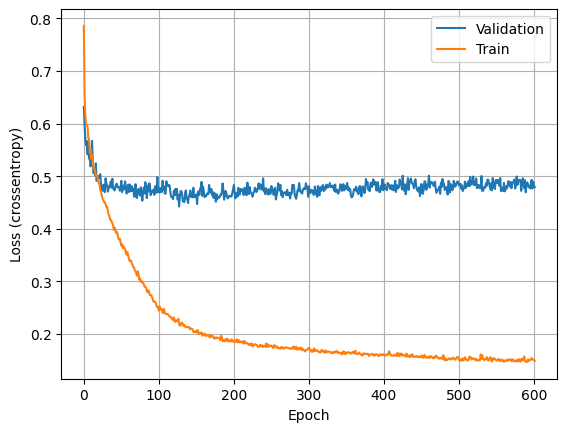

In [15]:
losses=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/regressive_lstm_loss.npy")
loss_train=losses[:,0]
loss_val=losses[:,1]
plt.plot(loss_val,label="Validation")
plt.plot(loss_train,label="Train")
plt.grid()
plt.ylabel("Loss (crossentropy)")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()

### predictions

In [10]:

device="cuda" if torch.cuda.is_available() else "cpu"
model = RegressiveLSTM(input_size=11, hidden_size=64, num_layers=2, output_size=60).to(device)

model.load_state_dict(torch.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/regressive_lstm_norm.pth", map_location=device))
model.eval()


/tmp/ipykernel_3371568/3258846503.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/regre

RegressiveLSTM(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=60, bias=True)
)

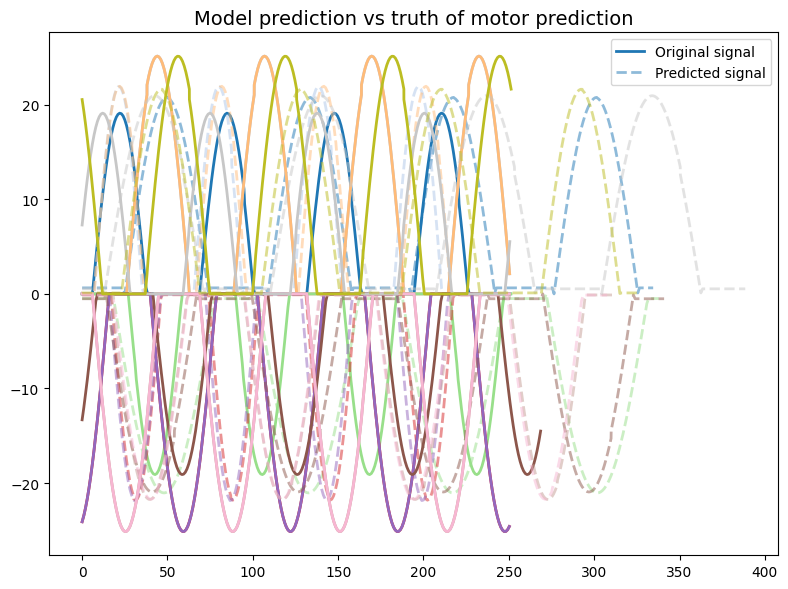

In [16]:
idx = np.random.randint(0,len(X))
x_sample = torch.tensor(X[idx],dtype=torch.float32)          # shape: [seq_len, 11]
y_true = scaler.inverse_transform(y)
y_true = y_true[idx]

x_sample = x_sample.unsqueeze(0)
model.eval()
with torch.no_grad():
    y_pred = model(x_sample.to(device)).cpu()
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred.squeeze(0).flatten()
cmap = plt.cm.tab20

plt.figure(figsize=(8,6))

for idx, i in enumerate(range(0, 60-5, 5)):
    # Choose a base colour for this iteration
    base_color = cmap(idx / 12)   # 12 iterations for range(0,55,5)
    # Make a lighter version for the predicted signal
    lighter_color = mcolors.to_rgba(base_color, alpha=0.5)
    # Take params
    params_m1 = y_true.flatten()[i:i+5]
    params_m2 = y_pred[i:i+5]
    x1, y1 = reform(*params_m1,repeat=4)
    x2, y2 = reform(*params_m2,repeat=4)
    # Plot original (use zorder to keep lines visible)
    plt.plot(
        x1, y1, 
        color=base_color, 
        linewidth=2,
        label="Original signal" if idx == 0 else "_nolegend_"
    )
    # Plot predicted
    plt.plot(
        x2, y2, 
        color=lighter_color, 
        linestyle="--", 
        linewidth=2,
        label="Predicted signal" if idx == 0 else "_nolegend_"
    )

plt.title("Model prediction vs truth of motor prediction", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
